<h2>Imports</h2>

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score 
# Removed KNeighborsClassifier import
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
import matplotlib.pyplot as plt 
import seaborn as sns

<h2>Data Loading and Preprocessing</h2>

In [13]:
# --- Configuration ---
DATA_FILE = "Crop_recommendation.csv"
RANDOM_SEED = 42

# --- 1. Data Loading ---
print(f"Loading data from {DATA_FILE}...")
try:
    df = pd.read_csv(DATA_FILE)
except Exception as e:
    print(f"Error loading file: {e}")
    df = pd.DataFrame() 
    exit()

# --- 2. Feature Engineering & Selection ---
print("Applying Feature Engineering (N:K, P:K Ratios, NPK Sum, Moisture Index)...")
# Safely calculate ratios, replacing division-by-zero results with NaN
df['N_to_K'] = df.apply(lambda row: row['N'] / row['K'] if row['K'] != 0 else np.nan, axis=1)
df['P_to_K'] = df.apply(lambda row: row['P'] / row['K'] if row['K'] != 0 else np.nan, axis=1)
df['NPK_Sum'] = df['N'] + df['P'] + df['K']
df['Moisture_Index'] = df.apply(lambda row: row['humidity'] / row['rainfall'] if row['rainfall'] != 0 else np.nan, axis=1)

# Impute NaNs created by division-by-zero with the mean of the new feature
df.fillna(df.mean(numeric_only=True), inplace=True) 

# --- 3. Preprocessing: Split and Scale (Outlier Robust Scaling Implemented) ---
X = df.drop(['label'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# *** OUTLIER FIX IMPLEMENTATION: RobustScaler ***
print("\nFIXING OUTLIERS: Using RobustScaler for sensitive models...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Loading data from Crop_recommendation.csv...
Applying Feature Engineering (N:K, P:K Ratios, NPK Sum, Moisture Index)...

FIXING OUTLIERS: Using RobustScaler for sensitive models...


<h2>Plotting Functions</h2>

In [14]:
# --- Plotting Functions ---

def plot_confusion_matrix(cm, class_names, name):
    """Plots the confusion matrix."""
    plt.figure(figsize=(12, 10))
    # Use a modern color scheme and ensure readability
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='rocket_r', # Changed to a high-contrast palette
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix for {name}', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_learning_curve(model, X, y, title, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), is_scaled=False):
    """Plots the learning curve to visualize bias-variance trade-off."""
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=16)
    plt.xlabel("Training Examples", fontsize=14)
    plt.ylabel("Score (Accuracy)", fontsize=14)
    
    # Use the appropriate data for the learning curve
    X_curve = X_train_scaled if is_scaled and 'X_train_scaled' in globals() else X
    
    # Generate the learning curve scores
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_curve, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the curves
    plt.grid(linestyle='--')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#2ecc71") # Greenish
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#e74c3c") # Reddish
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#27ae60", label="Training score (High Bias Check)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#c0392b", label="Cross-validation score (High Variance Check)")
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

<h2>Models Evaluation Function</h2>

In [15]:
def evaluate_and_report(model, X_train, y_train, X_test, y_test, name, is_scaled=False):
    """Trains, evaluates, and reports metrics for a single model."""
    
    # Determine which data set to use based on model scaling requirement
    X_train_data = X_train_scaled if is_scaled and 'X_train_scaled' in globals() else X_train
    X_test_data = X_test_scaled if is_scaled and 'X_test_scaled' in globals() else X_test
    
    # Train the model
    print(f"\nTraining {name}...")
    model.fit(X_train_data, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_difference = train_accuracy - test_accuracy
    
    # Calculate Cross-Validation Score (using the training data)
    cv_data = X_train_scaled if is_scaled else X_train
    cv_scores = cross_val_score(model, cv_data, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_mean_score = np.mean(cv_scores)

    # --- Bias/Variance Estimation ---
    bias_estimate = "Low" if train_accuracy > 0.90 else "High"
    variance_estimate = "Low" if (train_accuracy - cv_mean_score) < 0.02 else "High" 

    print(f"\n--- {name} Performance ---")
    print(f"Training Set Accuracy: {train_accuracy:.4f} ({(train_accuracy * 100):.2f}%)")
    print(f"Cross-Validation (CV) Score: {cv_mean_score:.4f} ({(cv_mean_score * 100):.2f}%)")
    print(f"Test Set Accuracy: {test_accuracy:.4f} ({(test_accuracy * 100):.2f}%)")
    print(f"Bias Estimate: {bias_estimate} (Train score is high)")
    print(f"Variance Estimate: {variance_estimate} (Train-CV gap is {(train_accuracy - cv_mean_score)*100:.2f}%)")


    # Bias/Variance Interpretation 
    if accuracy_difference > 0.05:
        print("Interpretation: High Variance (Possible Overfitting). Test set accuracy significantly lower than training set.")
    elif train_accuracy < 0.90 and test_accuracy < 0.90:
        print("Interpretation: High Bias (Possible Underfitting). Model is too simple or features are insufficient.")
    else:
        print("Interpretation: Balanced Fit. High performance on both sets, suggesting low bias and manageable variance.")

    print("\nDetailed Training Set Classification Report:")
    print(classification_report(y_train, y_train_pred, zero_division=0))

    print("\nDetailed Test Set Classification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=0))
    
    # Generate and plot Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
    plot_confusion_matrix(cm, model.classes_, name)

    # Generate and plot Learning Curve
    plot_learning_curve(
        model, 
        X_train, 
        y_train, 
        title=f"{name} Learning Curve",
        is_scaled=is_scaled 
    )
    
    # Return the metrics for the history table
    return model, {
        'Model': name,
        'Train Accuracy': train_accuracy,
        'CV Score': cv_mean_score,
        'Test Accuracy': test_accuracy,
        'Bias Estimate': bias_estimate,
        'Variance Estimate': variance_estimate,
        'is_scaled': is_scaled # Include scaling status for prediction
    }


<h2>Defining & Training ML Models</h2>


--- Starting Multi-Model Training and Evaluation ---

Training Support Vector Classifier (SVC)...



--- Support Vector Classifier (SVC) Performance ---
Training Set Accuracy: 0.9926 (99.26%)
Cross-Validation (CV) Score: 0.9858 (98.58%)
Test Set Accuracy: 0.9773 (97.73%)
Bias Estimate: Low (Train score is high)
Variance Estimate: Low (Train-CV gap is 0.68%)
Interpretation: Balanced Fit. High performance on both sets, suggesting low bias and manageable variance.

Detailed Training Set Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        77
      banana       1.00      1.00      1.00        79
   blackgram       1.00      1.00      1.00        80
    chickpea       1.00      1.00      1.00        74
     coconut       1.00      1.00      1.00        73
      coffee       1.00      1.00      1.00        83
      cotton       0.99      1.00      0.99        83
      grapes       1.00      1.00      1.00        86
        jute       0.88      0.97      0.93        77
 kidneybeans       1.00      1.00      1.00    

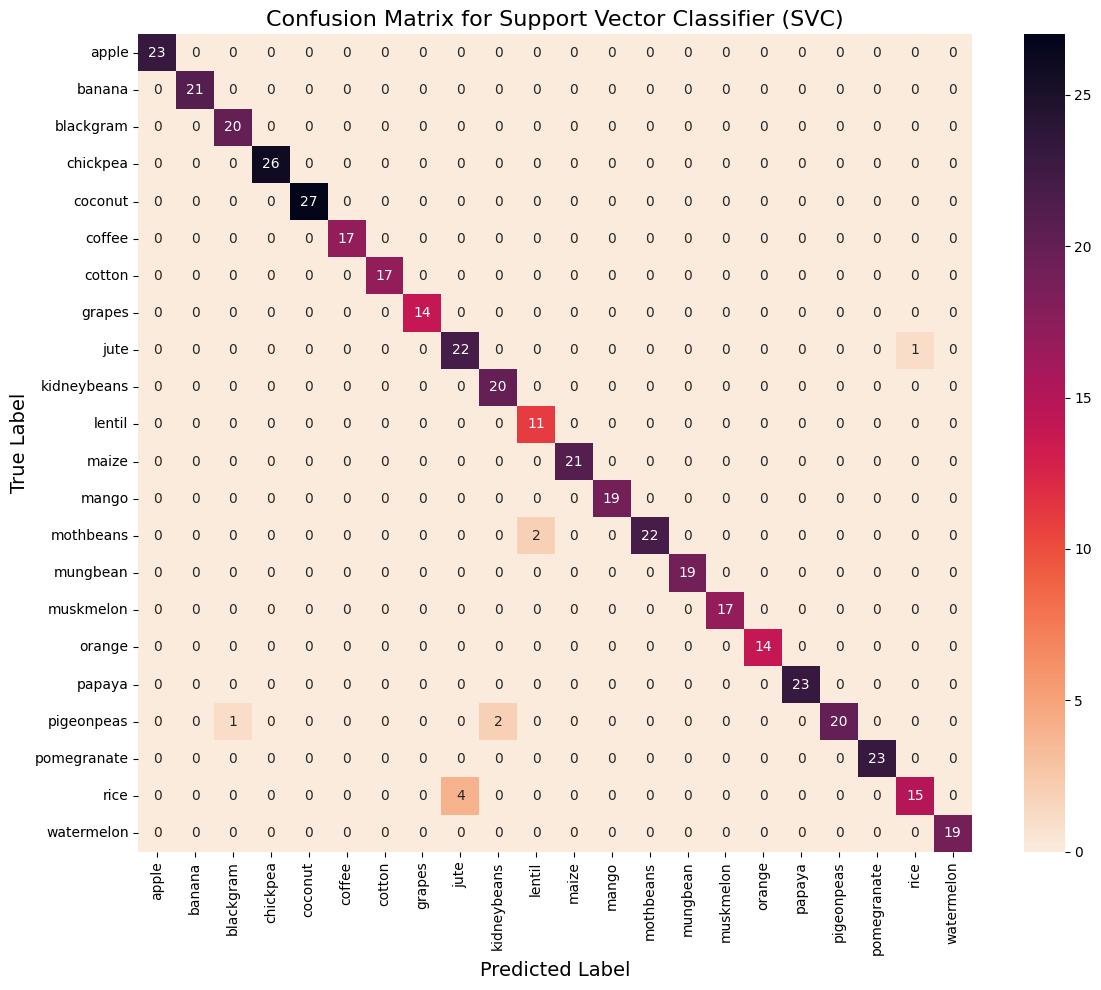

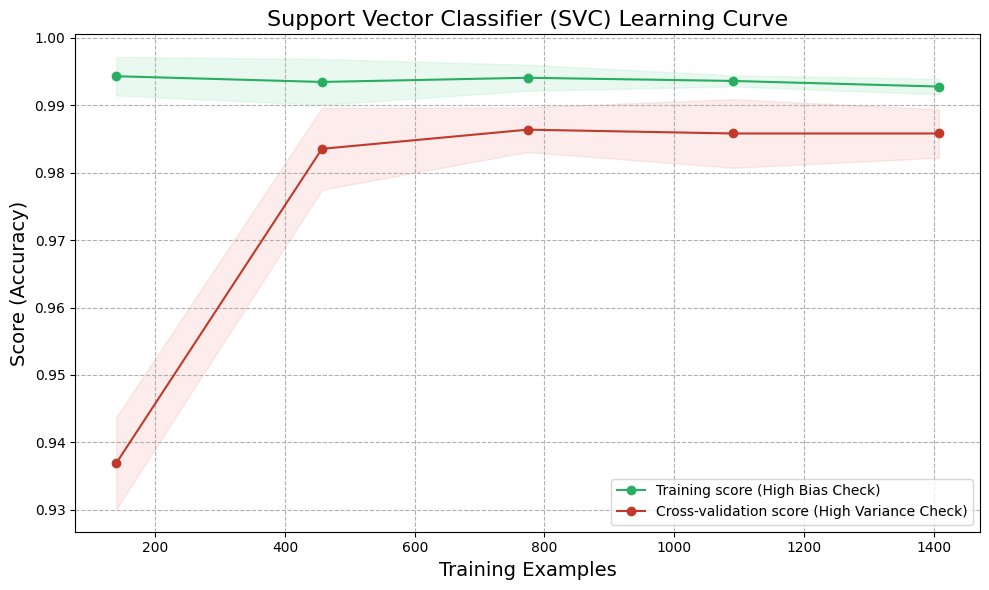


Training Random Forest Classifier (RFC)...

--- Random Forest Classifier (RFC) Performance ---
Training Set Accuracy: 0.9972 (99.72%)
Cross-Validation (CV) Score: 0.9920 (99.20%)
Test Set Accuracy: 0.9909 (99.09%)
Bias Estimate: Low (Train score is high)
Variance Estimate: Low (Train-CV gap is 0.51%)
Interpretation: Balanced Fit. High performance on both sets, suggesting low bias and manageable variance.

Detailed Training Set Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        77
      banana       1.00      1.00      1.00        79
   blackgram       1.00      1.00      1.00        80
    chickpea       1.00      1.00      1.00        74
     coconut       1.00      1.00      1.00        73
      coffee       1.00      1.00      1.00        83
      cotton       1.00      1.00      1.00        83
      grapes       1.00      1.00      1.00        86
        jute       0.94      1.00      0.97        77
 kid

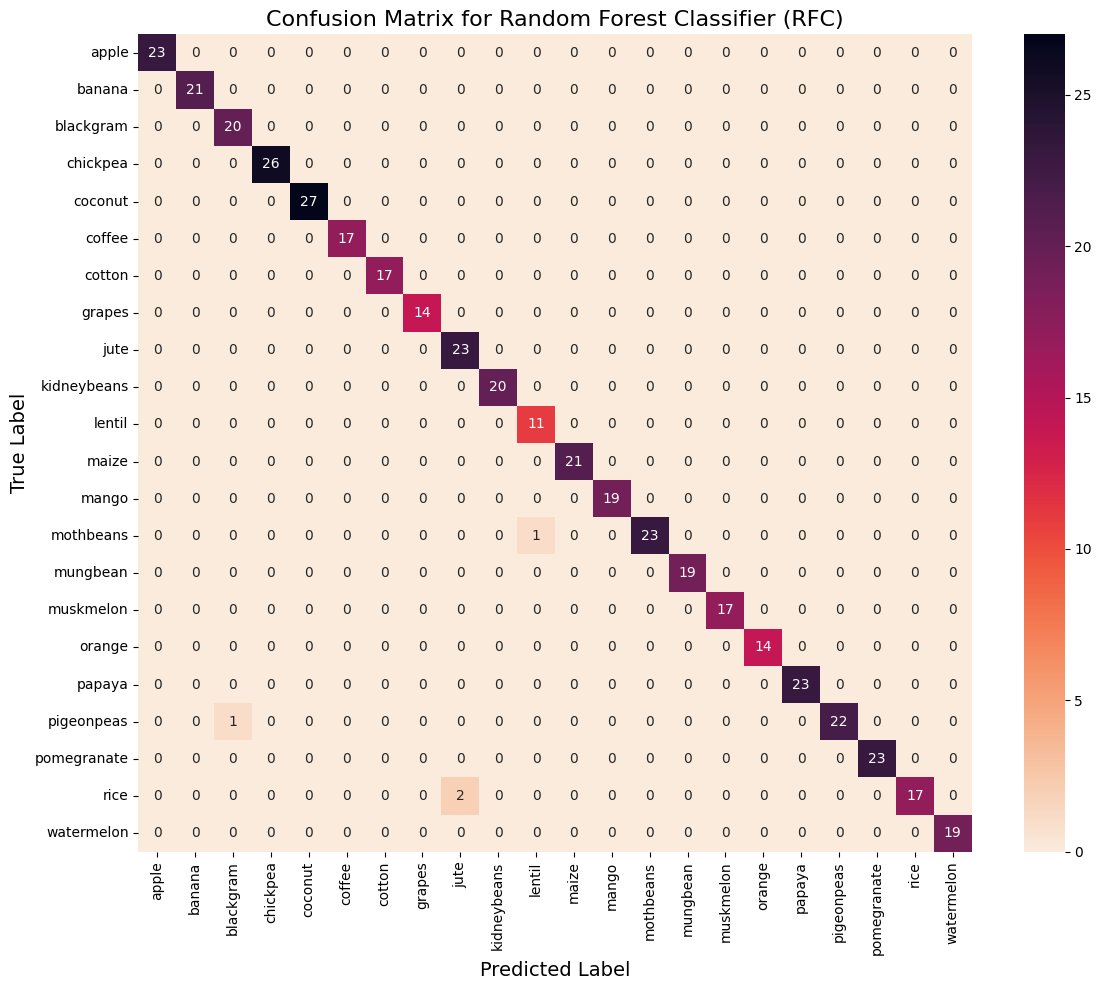

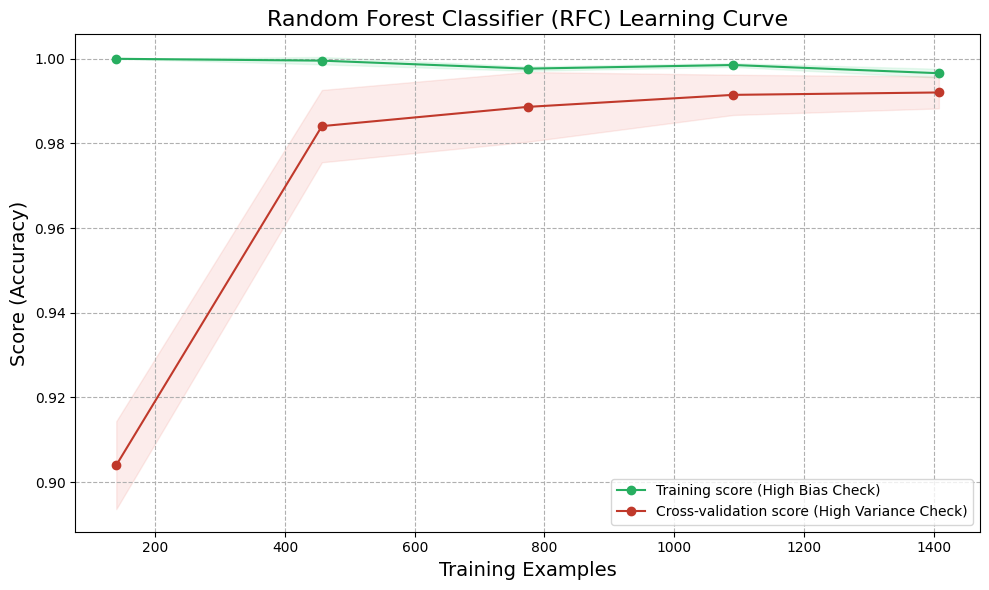


Training AdaBoost Classifier (ADA)...

--- AdaBoost Classifier (ADA) Performance ---
Training Set Accuracy: 0.9989 (99.89%)
Cross-Validation (CV) Score: 0.9830 (98.30%)
Test Set Accuracy: 0.9841 (98.41%)
Bias Estimate: Low (Train score is high)
Variance Estimate: Low (Train-CV gap is 1.59%)
Interpretation: Balanced Fit. High performance on both sets, suggesting low bias and manageable variance.

Detailed Training Set Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        77
      banana       1.00      1.00      1.00        79
   blackgram       0.99      1.00      0.99        80
    chickpea       1.00      1.00      1.00        74
     coconut       1.00      1.00      1.00        73
      coffee       1.00      1.00      1.00        83
      cotton       1.00      1.00      1.00        83
      grapes       1.00      1.00      1.00        86
        jute       0.99      1.00      0.99        77
 kidneybeans  

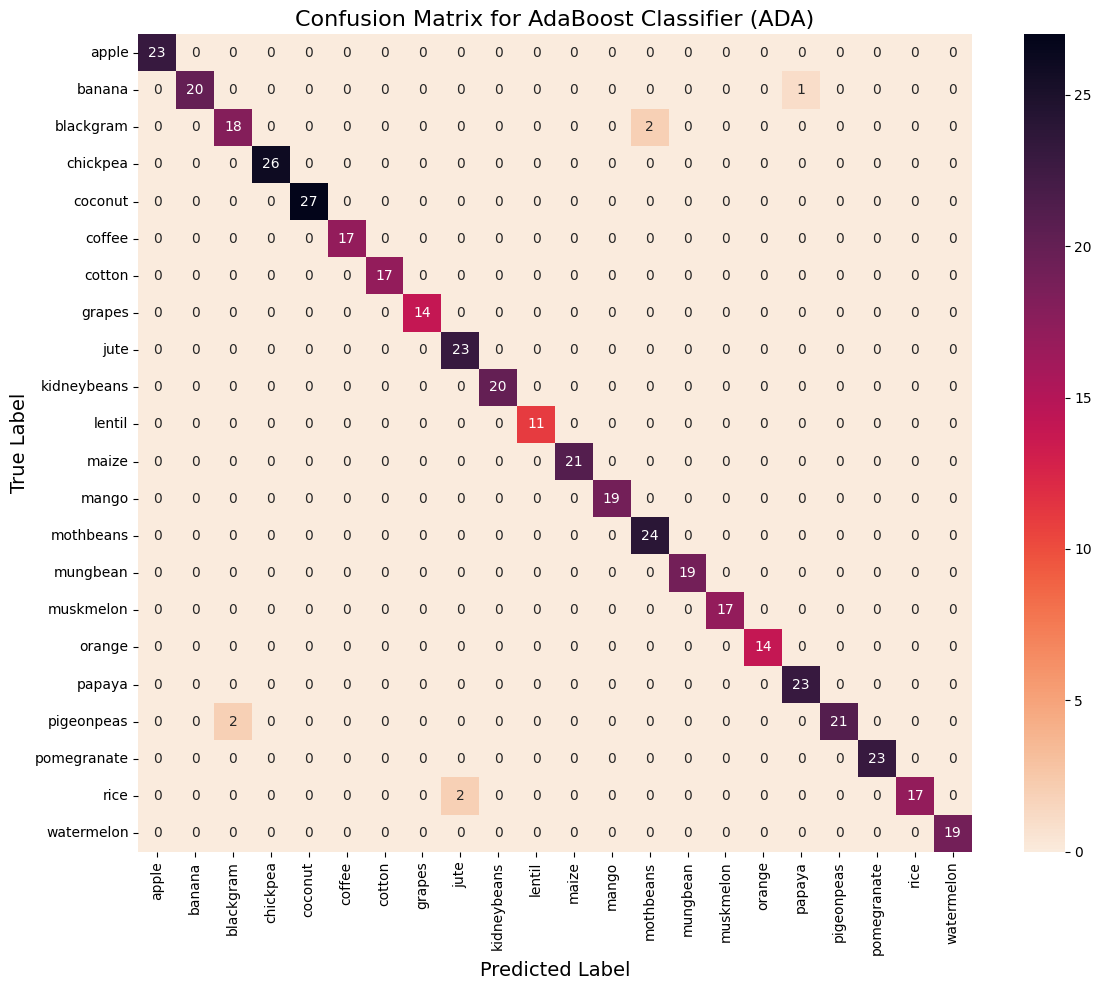

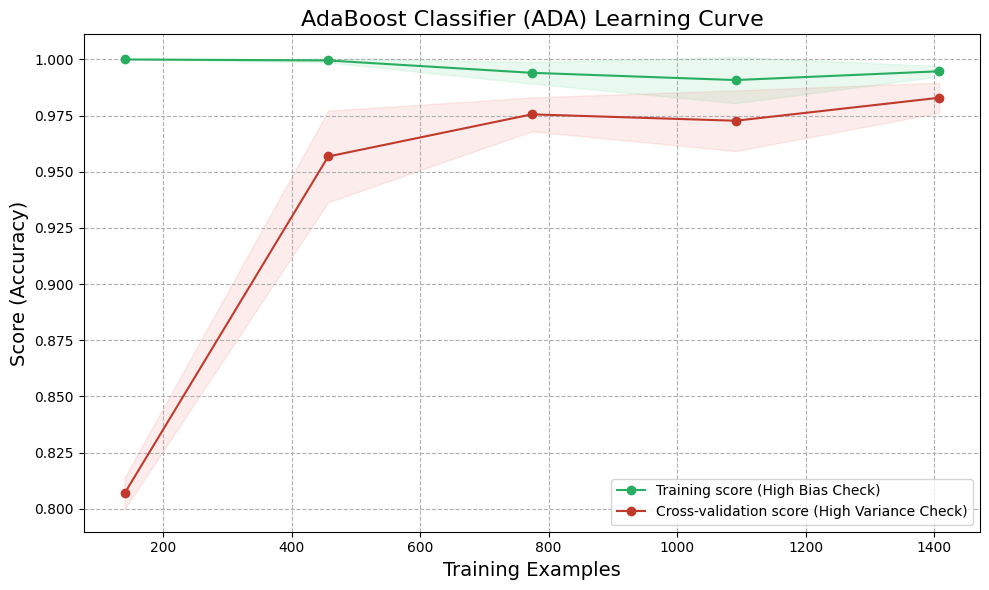


Training Gaussian Naive Bayes (GNB)...

--- Gaussian Naive Bayes (GNB) Performance ---
Training Set Accuracy: 0.9938 (99.38%)
Cross-Validation (CV) Score: 0.9926 (99.26%)
Test Set Accuracy: 0.9909 (99.09%)
Bias Estimate: Low (Train score is high)
Variance Estimate: Low (Train-CV gap is 0.11%)
Interpretation: Balanced Fit. High performance on both sets, suggesting low bias and manageable variance.

Detailed Training Set Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        77
      banana       1.00      1.00      1.00        79
   blackgram       1.00      0.97      0.99        80
    chickpea       1.00      1.00      1.00        74
     coconut       1.00      1.00      1.00        73
      coffee       1.00      1.00      1.00        83
      cotton       0.99      1.00      0.99        83
      grapes       1.00      1.00      1.00        86
        jute       0.92      0.99      0.95        77
 kidneybeans

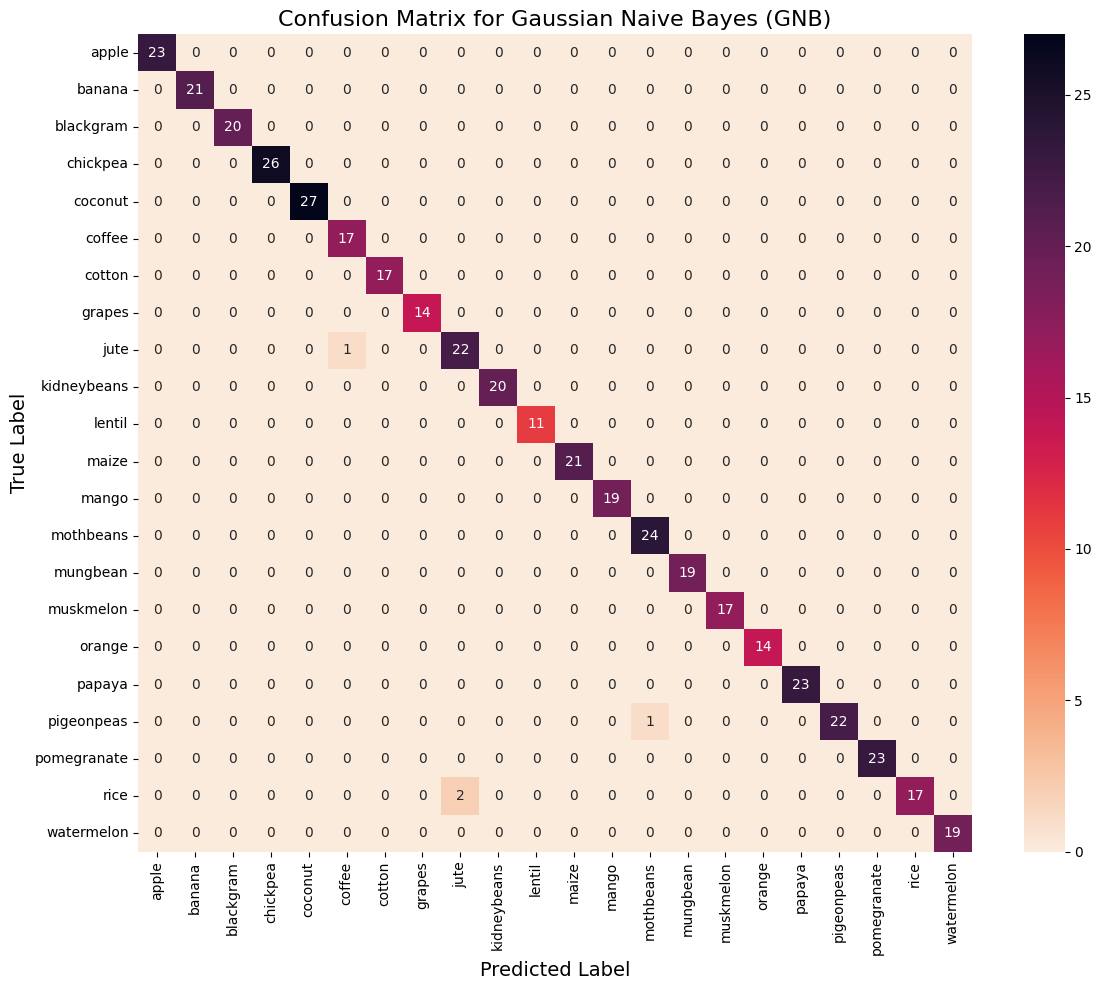

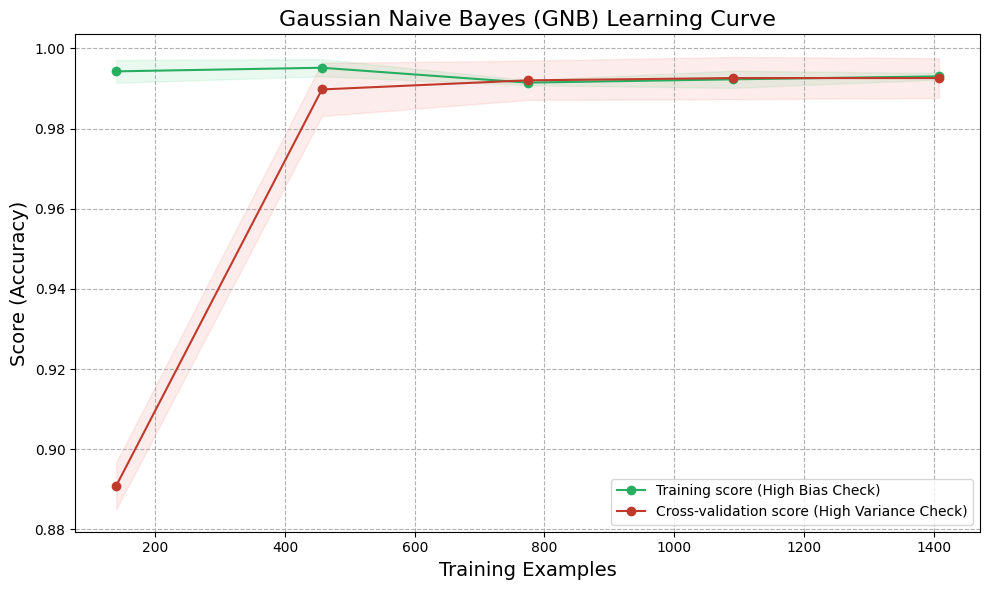


--- All models trained and evaluated. ---

--- Model Performance History Table ---
| Model                           | Train Accuracy   | CV Score   | Test Accuracy   | Bias Estimate   | Variance Estimate   | is_scaled   |
|:--------------------------------|:-----------------|:-----------|:----------------|:----------------|:--------------------|:------------|
| Support Vector Classifier (SVC) | 0.9926           | 0.9858     | 0.9773          | Low             | Low                 | True        |
| Random Forest Classifier (RFC)  | 0.9972           | 0.992      | 0.9909          | Low             | Low                 | False       |
| AdaBoost Classifier (ADA)       | 0.9989           | 0.983      | 0.9841          | Low             | Low                 | False       |
| Gaussian Naive Bayes (GNB)      | 0.9938           | 0.9926     | 0.9909          | Low             | Low                 | False       |


In [ ]:
# --- 4. Define and Train ALL ML Models ---

# Define the models and whether they require scaled data (True/False)
models_to_test = [
    # Sensitive models now use RobustScaler 
    (SVC(random_state=RANDOM_SEED, C=10.0, gamma='auto'), "Support Vector Classifier (SVC)", True),
    
    # Robust models (Tree-based/Naive Bayes) use unscaled data
    (RandomForestClassifier(
        random_state=RANDOM_SEED, 
        n_estimators=100, 
        max_depth=10, 
        min_samples_split=5 
    ), "Random Forest Classifier (RFC)", False),
    (AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3), 
        n_estimators=100, 
        random_state=RANDOM_SEED, 
        learning_rate=0.5 
    ), "AdaBoost Classifier (ADA)", False),
    (GaussianNB(), "Gaussian Naive Bayes (GNB)", False)
]

print("\n--- Starting Multi-Model Training and Evaluation ---")
trained_models = {}
history_data = [] 

for model_instance, name, is_scaled in models_to_test:
    trained_model, metrics = evaluate_and_report(
        model_instance, 
        X_train, y_train, 
        X_test, y_test, 
        name, 
        is_scaled
    )
    trained_models[name] = trained_model
    history_data.append(metrics) 

print("\n--- All models trained and evaluated. ---")

# --- 5. Final Model Comparison (History Table) ---
print("\n--- Model Performance History Table ---")
history_df = pd.DataFrame(history_data)
for col in ['Train Accuracy', 'CV Score', 'Test Accuracy']:
    history_df[col] = history_df[col].map('{:.4f}'.format)
    
print(history_df.to_markdown(index=False, numalign="left", stralign="left"))

<h2>Example Prediction with Best Model</h2>

In [17]:

print("\n--- Example Prediction ---")

# 1. Determine the best model dynamically based on Test Accuracy
history_df['Test Accuracy Numeric'] = history_df['Test Accuracy'].astype(float)
best_model_metrics = history_df.loc[history_df['Test Accuracy Numeric'].idxmax()]

best_model_name = best_model_metrics['Model']
best_model_is_scaled = best_model_metrics['is_scaled']
best_model = trained_models[best_model_name]

print(f"Selecting best model for prediction: {best_model_name} (Test Accuracy: {best_model_metrics['Test Accuracy']})")

# Define a list of new data points to test
new_data_points = [
    [79, 30, 52, 27.33, 86.59, 6.5, 239.2], # Expected: rice
    [1, 62, 28, 31.86, 90.5, 5.0, 45.05], # Expected: mungbean
    [5, 20, 50, 25.5, 84.2, 8.0, 100.6] # Expected: pomegranate
]

# Create new data DataFrame
new_data_df = pd.DataFrame(
    new_data_points, 
    columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
)

# Apply Feature Engineering
new_data_df['N_to_K'] = new_data_df.apply(lambda row: row['N'] / row['K'] if row['K'] != 0 else np.nan, axis=1)
new_data_df['P_to_K'] = new_data_df.apply(lambda row: row['P'] / row['K'] if row['K'] != 0 else np.nan, axis=1)
new_data_df['NPK_Sum'] = new_data_df['N'] + new_data_df['P'] + new_data_df['K']
new_data_df['Moisture_Index'] = new_data_df.apply(lambda row: row['humidity'] / row['rainfall'] if row['rainfall'] != 0 else np.nan, axis=1)
new_data_df.fillna(new_data_df.mean(numeric_only=True), inplace=True) 


# 2. Prepare the new data based on the best model's scaling requirement
if best_model_is_scaled:
    X_new_predict = scaler.transform(new_data_df)
    data_type = "ROBUSTLY SCALED"
else:
    X_new_predict = new_data_df
    data_type = "UNSCALED"

# 3. Perform the prediction using the best model
new_predictions = best_model.predict(X_new_predict) 
new_data_df['Predicted Crop'] = new_predictions

print(f"Model Recommendations for Unseen Data (using {best_model_name}, trained on {data_type} data):")
print(new_data_df.to_markdown(index=True, numalign="left", stralign="left"))

print("\nScript execution finished. Final prediction uses the best-performing model dynamically.")


--- Example Prediction ---
Selecting best model for prediction: Random Forest Classifier (RFC) (Test Accuracy: 0.9909)
Model Recommendations for Unseen Data (using Random Forest Classifier (RFC), trained on UNSCALED data):
|    | N   | P   | K   | temperature   | humidity   | ph   | rainfall   | N_to_K    | P_to_K   | NPK_Sum   | Moisture_Index   | Predicted Crop   |
|:---|:----|:----|:----|:--------------|:-----------|:-----|:-----------|:----------|:---------|:----------|:-----------------|:-----------------|
| 0  | 79  | 30  | 52  | 27.33         | 86.59      | 6.5  | 239.2      | 1.51923   | 0.576923 | 161       | 0.361998         | rice             |
| 1  | 1   | 62  | 28  | 31.86         | 90.5       | 5    | 45.05      | 0.0357143 | 2.21429  | 91        | 2.00888          | mungbean         |
| 2  | 5   | 20  | 50  | 25.5          | 84.2       | 8    | 100.6      | 0.1       | 0.4      | 75        | 0.836978         | pomegranate      |

Script execution finished. Final predict